<a href="https://colab.research.google.com/github/Tandon-A/emotic/blob/master/Colab_train_emotic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Emotions in context (Emotic) </center></h1>
<center> Using context information to recognize emotions in images</center>

<h1>Project context</h1>

Humans use their facial features or expressions to convey how they feel, such as a person may smile when happy and scowl when angry. Historically, computer vision research has focussed on analyzing and learning these facial features to recognize emotions. 
However, these facial features are not universal and vary extensively across cultures and situations. 

<figure>
<img src="https://raw.githubusercontent.com/Tandon-A/emotic/master/assets/face.jpg"> <img src="https://raw.githubusercontent.com/Tandon-A/emotic/master/assets/full_scene.jpg" width="400">
  <figcaption>Fig 1: a) (Facial feature) The person looks angry or in pain b) (Whole scene) The person looks elated.</figcaption>
</figure>


A scene context, as shown in the figure above, can provide additional information about the situations. This project explores the use of context in recognizing emotions in images. 

This project uses the <a href="http://sunai.uoc.edu/emotic/download.html">EMOTIC dataset</a> and follows the methodology as introduced in the paper <a href="https://arxiv.org/pdf/2003.13401.pdf">'Context based emotion recognition using EMOTIC dataset'</a>.

In [1]:
# Linking Google drive to use preprocessed data 
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


# I. Prepare places pretrained model

In [2]:
# Get Resnet18 model trained on places dataset. 
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

--2021-08-17 17:32:18--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.30.195.26
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.30.195.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43.40M  24.3MB/s    in 1.8s    

2021-08-17 17:32:20 (24.3 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



In [3]:
# Saving the model weights to use ahead in the notebook
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import os

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


# II. General imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model 

In [5]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features
    self.fc1 = nn.Linear((self.num_context_features + num_body_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cat = nn.Linear(256, 26)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()

    
  def forward(self, x_context, x_body):
    context_features = x_context.view(-1, self.num_context_features)
    body_features = x_body.view(-1, self.num_body_features)
    fuse_features = torch.cat((context_features, body_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)    
    cat_out = self.fc_cat(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cat_out, cont_out

print ('completed cell')

completed cell


## Emotic Dataset

In [6]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, y_cat, y_cont, transform, context_norm, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.y_cat = y_cat 
    self.y_cont = y_cont
    self.transform = transform 
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)
  
  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [7]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)
    
  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum() 

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Load preprocessed data

In [8]:
# Change data_src variable as per your drive
data_src = '/content/drive/My Drive/Colab/Emotic/data'


# Load training preprocessed data
train_context = np.load(os.path.join(data_src,'pre','train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'pre','train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src,'pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'pre','train_cont_arr.npy'))

# Load validation preprocessed data 
val_context = np.load(os.path.join(data_src,'pre','val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'pre','val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src,'pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'pre','val_cont_arr.npy'))

# Load testing preprocessed data
test_context = np.load(os.path.join(data_src,'pre','test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'pre','test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src,'pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'pre','test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [9]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]


train_transform = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToPILImage(), 
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_cat, train_cont, \
                                  train_transform, context_norm, body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont, \
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont, \
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. Prepare emotic model

In [10]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))


# print (summary(model_context, (3,224,224), device="cpu"))
# print (summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

completed cell


## Prepare optimizer

In [11]:
for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

print ('completed cell')

completed cell


# VI. Train model

In [12]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=0.5, cont_loss_param=0.5):
  if not os.path.exists(model_path):
    os.makedirs(model_path)
  
  min_loss = np.inf

  train_loss = list()
  val_loss = list()

  model_context, model_body, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_body.to(device)
    
    emotic_model.train()
    model_context.train()
    model_body.train()
    
    for images_context, images_body, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_body = images_body.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_body = model_body(images_body)

      pred_cat, pred_cont = emotic_model(pred_context, pred_body)
      cat_loss_batch = disc_loss(pred_cat, labels_cat)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
      running_loss += loss.item()
      loss.backward()
      opt.step()

    if e % 1 == 0: 
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)

    
    running_loss = 0.0 
    emotic_model.eval()
    model_context.eval()
    model_body.eval()
    
    with torch.no_grad():
      for images_context, images_body, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_body = images_body.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_body = model_body(images_body)
        
        pred_cat, pred_cont = emotic_model(pred_context, pred_body)
        cat_loss_batch = disc_loss(pred_cat, labels_cat)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
        running_loss += loss.item()

      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
      
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_body.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic1.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context1.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body1.pth'))

  print ('completed training')
  
  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train'])
  ax2.legend(['val'])

print ('completed cell')

completed cell


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch = 0 training loss = 64863.3032
epoch = 0 validation loss = 6286.3406
saving model at epoch e = 0
epoch = 1 training loss = 47588.2536
epoch = 1 validation loss = 5754.6668
saving model at epoch e = 1
epoch = 2 training loss = 45589.5908
epoch = 2 validation loss = 5753.7185
saving model at epoch e = 2
epoch = 3 training loss = 44254.9966
epoch = 3 validation loss = 5677.1488
saving model at epoch e = 3
epoch = 4 training loss = 43592.7128
epoch = 4 validation loss = 5722.5824
epoch = 5 training loss = 42938.6911
epoch = 5 validation loss = 5569.4062
saving model at epoch e = 5
epoch = 6 training loss = 42579.4593
epoch = 6 validation loss = 5796.7644
epoch = 7 training loss = 41934.0057
epoch = 7 validation loss = 5575.4900
epoch = 8 training loss = 41629.1832
epoch = 8 validation loss = 5591.6801
epoch = 9 training loss = 41416.1661
epoch = 9 validation loss = 5536.8152
saving model at epoch e = 9
epoch = 10 training loss = 41335.3265
epoch = 10 validation loss = 5505.6411
savin

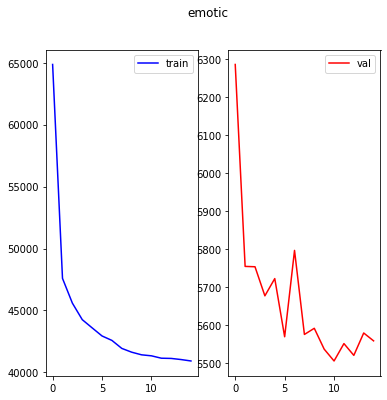

In [13]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1)

# VII. Test model

In [14]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [15]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, emotic_model = models
    cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_cat, pred_cont = emotic_model(pred_context, pred_body)

            cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10 
            indx = indx + pred_cat.shape[0]

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (ap_mean, vad_mean)
    return ap_mean, vad_mean 

print ('completed cell')

completed cell


In [16]:
model_context = torch.load('./models/model_context1.pth')
model_body = torch.load('./models/model_body1.pth')
emotic_model = torch.load('./models/model_emotic1.pth')

print ('completed cell')

completed cell


In [17]:
val_ap, val_vad = test_data([model_context, model_body, emotic_model], device, val_loader, val_dataset.__len__())
test_ap, test_vad = test_data([model_context, model_body, emotic_model], device, test_loader, test_dataset.__len__())

print ('validation Mean average precision=%.4f Mean VAD MAE=%.4f' %(val_ap, val_vad))
print ('testing Mean average precision=%.4f Mean VAD MAE=%.4f' %(test_ap, test_vad))

starting testing
completed testing
ap [0.3983917  0.18015468 0.22337271 0.95204633 0.17163357 0.7866947
 0.23361506 0.37178904 0.19096893 0.20868655 0.06009851 0.98069084
 0.26645675 0.7951143  0.13405906 0.08186857 0.8081806  0.16670538
 0.29040682 0.49211633 0.20419936 0.08260126 0.18704712 0.14419095
 0.3501988  0.11717057] (26,) 0.34147915
vad [0.70697206 0.8584789  0.86687875] (3,) 0.81077653
0.34147915 0.81077653
starting testing
completed testing
ap [0.29003292 0.08763415 0.14132965 0.56043494 0.07053518 0.75399864
 0.11882206 0.2385993  0.16040386 0.173684   0.01993784 0.86009395
 0.15641297 0.69662005 0.09915597 0.06025878 0.66563565 0.06506737
 0.21911173 0.4214436  0.17897978 0.05904196 0.1752331  0.08228464
 0.13343503 0.0820521 ] (26,) 0.2527015
vad [0.8996919 1.0314642 0.943558 ] (3,) 0.95823807
0.2527015 0.95823807
validation Mean average precision=0.3415 Mean VAD MAE=0.8108
testing Mean average precision=0.2527 Mean VAD MAE=0.9582


In [18]:
cat_labels = scipy.io.loadmat('./cat_labels.mat')
cat_preds = scipy.io.loadmat('./cat_preds.mat')
cat_preds = cat_preds['cat_preds']
cat_labels = cat_labels['cat_labels']
print (cat_preds.shape, cat_labels.shape)

#thesholds calculation for inference 
thresholds = get_thresholds(cat_preds, cat_labels)
print (thresholds, thresholds.shape)

print ('completed cell')

(26, 7203) (26, 7203)
[0.11334415 0.32935348 0.17811956 0.1820814  0.24816841 0.13238849
 0.23765785 0.10895684 0.07811652 0.07971309 0.14207679 0.47783324
 0.08085962 0.14741261 0.12622227 0.12906708 0.22126663 0.2721243
 0.10970519 0.10124312 0.18777776 0.14807722 0.2636854  0.09791826
 0.0983988  0.0875175 ] (26,)
completed cell


# VIII. Average Precision computation using <a href="https://1drv.ms/u/s!AkYHbdGNmIVCgbYZB_dY3wuWJou_5A?e=jcsZUj">author's script</a>

In [ ]:
!apt install octave

Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave is already the newest version (4.2.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
%%writefile eval.m

gt = load('./cat_labels.mat')
gt = gt.cat_labels

pred = load('./cat_preds.mat')
pred = pred.cat_preds

categories{1} = 'Affection';
categories{2} = 'Anger';
categories{3} = 'Annoyance';
categories{4} = 'Anticipation';
categories{5} = 'Aversion';
categories{6} = 'Confidence';
categories{7} = 'Disapproval';
categories{8} = 'Disconnection';
categories{9} = 'Disquietment';
categories{10} = 'Doubt/Confusion';
categories{11} = 'Embarrassment';
categories{12} = 'Engagement';
categories{13} = 'Esteem';
categories{14} = 'Excitement';
categories{15} = 'Fatigue';
categories{16} = 'Fear';
categories{17} = 'Happiness';
categories{18} = 'Pain';
categories{19} = 'Peace';
categories{20} = 'Pleasure';
categories{21} = 'Sadness';
categories{22} = 'Sensitivity';
categories{23} = 'Suffering';
categories{24} = 'Surprise';
categories{25} = 'Sympathy';
categories{26} = 'Yearning';


for c = 1:length(categories)
  confidence = pred(c,:)'; 
  testClass = gt(c,:)';
  confidence = double(confidence);

  S = rand('state');
  rand('state',0);
  confidence = confidence + rand(size(confidence))*10^(-10);
  rand('state',S)

  [S,j] = sort(-confidence);
  C = testClass(j);
  n = length(C);
    
  REL = sum(C);
  if n>0
    RETREL = cumsum(C);
    RET    = (1:n)';
  else
    RETREL = 0;
    RET    = 1;
  end

  precision = 100*RETREL ./ RET;
  recall    = 100*RETREL  / REL;
  th = -S;

  % compute AP
  mrec=[0 ; recall ; 100];
  mpre=[0 ; precision ; 0];
  for i=numel(mpre)-1:-1:1
    mpre(i)=max(mpre(i),mpre(i+1));
  end
  i=find(mrec(2:end)~=mrec(1:end-1))+1;
  averagePrecision=sum((mrec(i)-mrec(i-1)).*mpre(i))/100;
  ap_list(c)  = averagePrecision
end

display('#######################################')

display('Average precision of predictions');
for c = 1:length(categories)
    sp = '............................';
    cat = strcat(categories{c}, sp);
    cat = cat(1:18);
    display(cat);
    display(ap_list(c));
end

Overwriting eval.m


In [ ]:
!octave -W eval.m